## Density decomposition
Motivation: Need an unambiguous density decomposition stating which density belongs to which atom.

Idea: Use alchemy to grow a molecule from original locations far away.
$$\rho_t = \int_r^t d\lambda \partial_\lambda\rho = \int_r^t d\lambda \sum_I \frac{\partial\rho}{\partial Z_I}\frac{\partial Z_I}{\partial\lambda}=  \sum_I \Delta Z_I\int_r^t d\lambda\frac{\partial\rho}{\partial Z_I}$$

In [15]:
import horton
import numpy as np
import matplotlib.pyplot as plt

## Diatomics

In [35]:
def do_run(refdist, targetdist, pseudo, z1, z2, zsuper, gridpoints):
    mol = horton.IOData(title='test')
    mol.coordinates = np.array([[0.0, 0.0, -refdist/2], [0.0, 0.0, -targetdist/2], [0.0, 0.0, targetdist/2], [0.0, 0.0, refdist/2]]) * horton.angstrom
    mol.numbers = np.array([z1, z1, z2, z2])
    mol.pseudo_numbers = pseudo
    
    obasis = horton.get_gobasis(mol.coordinates, np.array([zsuper[0]]*4), 'STO-3G')
    for z in zsuper[1:]:
        obasis2 = horton.get_gobasis(mol.coordinates, np.array([z]*4), 'STO-3G')
        obasis = obasis.concatenate(obasis2)
    
    olp = obasis.compute_overlap()
    kin = obasis.compute_kinetic()
    na = obasis.compute_nuclear_attraction(mol.coordinates, mol.pseudo_numbers)
    er = obasis.compute_electron_repulsion()
    
    orb_alpha = horton.Orbitals(obasis.nbasis)
    orb_beta = horton.Orbitals(obasis.nbasis)

    # Initial guess
    one = kin + na
    horton.guess_core_hamiltonian(olp, one, orb_alpha, orb_beta)
    
    external = {'nn': horton.compute_nucnuc(mol.coordinates, mol.pseudo_numbers)}
    terms = [
        horton.UTwoIndexTerm(kin, 'kin'),
        horton.UDirectTerm(er, 'hartree'),
        horton.UExchangeTerm(er, 'x_hf'),
        horton.UTwoIndexTerm(na, 'ne'),
    ]
    ham = horton.UEffHam(terms, external)
    
    occ_model = horton.AufbauOccModel(7, 7)
        
    occ_model.assign(orb_alpha, orb_beta)
    dm_alpha = orb_alpha.to_dm()
    dm_beta = orb_beta.to_dm()
    #scf_solver = horton.ODASCFSolver(1e-6)
    scf_solver = horton.EDIIS2SCFSolver(1e-6)
    scf_solver(ham, olp, occ_model, dm_alpha, dm_beta)
    
    rho_grid = obasis.compute_grid_density_dm(dm_alpha, gridpoints)
    rho_grid += obasis.compute_grid_density_dm(dm_beta, gridpoints)
    
    return rho_grid

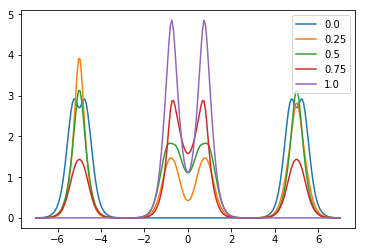

In [44]:
def trace_derivative(refdist, targetdist, z1, z2):
    horton.log.set_level(0)
    # build grid
    xs = np.linspace(-2, 2, 10)*horton.angstrom
    ys = np.linspace(-2, 2, 10)*horton.angstrom
    zs = np.linspace(-refdist/2-2, refdist/2+2, 200)*horton.angstrom
    grid = np.column_stack(map(np.ndarray.ravel, np.meshgrid(xs, ys, zs)))
    
    for lval in np.linspace(0, 1, 5):
        rho = do_run(refdist, targetdist, (z1*(1-lval), z1*lval, z2*lval, z2*(1-lval)), z1, z2, [7], grid)
        proj = []
        for zcoord in zs:
            proj.append(np.sum(rho[grid[:, 2] == zcoord]))
        plt.plot(zs/horton.angstrom, proj, label='%s' % lval)
    plt.legend()
trace_derivative(10, 1.5, 7, 7)